In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api


import sys
sys.path.insert(1, './helpers')
from preprocessing import utils_preprocess_text
from summary import result_summary
import pickle

In [2]:
# %%time
# VECTORIZATION = 'CountVectorizer' # CountVectorizer, TfidfVectorizer
VECTORIZATION = 'TfidfVectorizer'

# CLASSIFIER = 'GradientBoostingClassifier' # GradientBoostingClassifier, RandomForestClassifier, MultinomialNB
# CLASSIFIER = 'RandomForestClassifier'
CLASSIFIER = 'MultinomialNB'


In [3]:
with open('./source/wiki_fine_dtf.pickle', 'rb') as handle:
    dtf = pickle.load(handle)

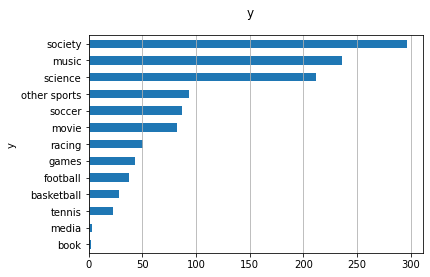

In [4]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.savefig('data_distribution.png')

In [5]:
dtf= dtf[dtf['y'].isin(['science', 'basketball', 'soccer', 
                        'racing', 'other sports',
#     'tennis', 
                        'society', 'music', 'movie', 'games', 'football'])]

In [6]:
dtf['X'] = dtf['columns'] + ' ' +\
            dtf['values'] # + ' ' +\

In [7]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import timeit

start_time = timeit.default_timer()


lst_stopwords = nltk.corpus.stopwords.words("english")

columns_to_clean = ['pg_title', 'section_title', 'table_caption', 
                    'columns', 'values']

for column in columns_to_clean:
    dtf[column] = dtf[column].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
# dtf.head()

dtf["text_clean"] = dtf["X"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

if VECTORIZATION == 'TfidfVectorizer':
## Count (classic BoW)
    vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))
else:
## Tf-Idf (advanced variant of BoW)
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

columns_to_clean = ['pg_title', 'section_title', 'table_caption', 
                    'columns', 'values']

corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

from sklearn import feature_selection 
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()


if VECTORIZATION == 'TfidfVectorizer':
    vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
else:
    vectorizer = feature_extraction.text.CountVectorizer(vocabulary=X_names)

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

if (CLASSIFIER == 'GradientBoostingClassifier'):
    classifier = GradientBoostingClassifier(random_state=0)
elif CLASSIFIER == 'RandomForestClassifier':
    classifier = RandomForestClassifier(max_depth=2, random_state=0)
else:
    classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

elapsed = timeit.default_timer() - start_time
print (elapsed)

6.302447505


baseline

In [8]:

# X_train = dtf_train[['num_col', 'num_row', 'max_cell_length', 'avg_length', 'length_variance']]
# X_test = dtf_test[['num_col', 'num_row', 'max_cell_length', 'avg_length', 'length_variance']]

# classifier = GradientBoostingClassifier(random_state=0)
# classifier.fit(X_train.values, y_train)

# predicted = classifier.predict(X_test)
# predicted_prob = classifier.predict_proba(X_test)

In [9]:
predicted_prob.shape

(351, 10)

Accuracy: 0.72
Auc: 0.93
Detail:
              precision    recall  f1-score   support

  basketball       0.00      0.00      0.00         7
    football       0.00      0.00      0.00        12
       games       0.00      0.00      0.00        13
       movie       0.88      0.28      0.42        25
       music       0.85      0.96      0.90        76
other sports       0.92      0.41      0.57        29
      racing       1.00      0.33      0.50        12
     science       0.85      0.80      0.82        55
      soccer       0.94      0.63      0.76        27
     society       0.56      1.00      0.72        95

    accuracy                           0.72       351
   macro avg       0.60      0.44      0.47       351
weighted avg       0.71      0.72      0.67       351



/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


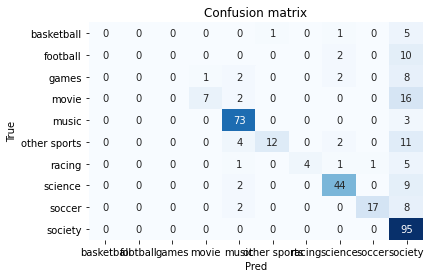

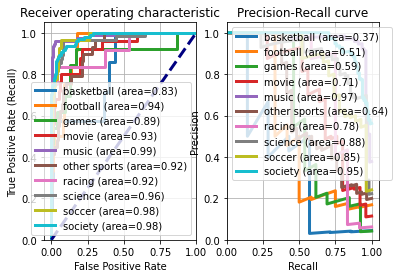

In [10]:
result_summary(y_test, predicted, predicted_prob, VECTORIZATION+'_'+CLASSIFIER+'_')